In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Dataset/plantvillage_dataset/color"


 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [ ]:
allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
] # 5 CLASSES


In [ ]:
import os
dataset_path = "/content/drive/MyDrive/Dataset/plantvillage_dataset/color"

selected_classes = [
    cls for cls in allowed_classes
    if os.path.isdir(os.path.join(dataset_path, cls))
]

print("Selected Classes:")
for cls in selected_classes:
    print(cls)

print("Number of classes:", len(selected_classes))


Selected Classes:
Tomato___Target_Spot
Pepper,_bell___Bacterial_spot
Grape___Black_rot
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Number of classes: 5


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

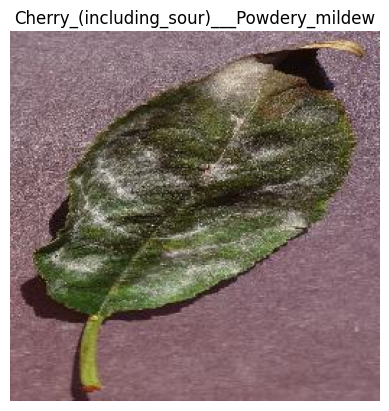

In [ ]:
import random
import os
import cv2
import matplotlib.pyplot as plt


class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)

img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(class_name)
plt.axis("off")


In [ ]:
import tensorflow as tf
EfficientNetB3 = tf.keras.applications.EfficientNetB3
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

#resize
IMG_SIZE = 256
BATCH_SIZE = 16
SEED = 42

#normzlization
def normalize_efficientnet(x, y):
    x = tf.cast(x, tf.float32)
    x = (x / 127.5) - 1.0
    return x, y


full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=selected_classes,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical", # one-hot encoded
    shuffle=True,
    seed=SEED
)

full_ds = full_ds.map(normalize_efficientnet,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 5825 files belonging to 5 classes.


In [ ]:
#CHECK FOR NORMALIZATION AND RESIZING
for images, labels in full_ds.take(1):
    print("Min:", tf.reduce_min(images).numpy())
    print("Max:", tf.reduce_max(images).numpy())
    print("Shape:", images.shape)

Min: -1.0
Max: 1.0
Shape: (16, 256, 256, 3)


In [ ]:
#(70% train, 15% val, 15% test)
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)

val_ds  = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)


In [ ]:
print("Total batches in full_ds :", tf.data.experimental.cardinality(full_ds).numpy())
print("Train batches           :", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches      :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches            :", tf.data.experimental.cardinality(test_ds).numpy())

Total batches in full_ds : 365
Train batches           : 255
Validation batches      : 54
Test batches            : 56


In [ ]:
def count_images(ds):
    return sum(1 for _ in ds.unbatch())

print("Total images :", count_images(full_ds))
print("Train images :", count_images(train_ds))
print("Val images   :", count_images(val_ds))
print("Test images  :", count_images(test_ds))


Total images : 5825
Train images : 4080
Val images   : 864
Test images  : 881


In [ ]:
#DYNAMIC AUGMENTATION (TRAIN ONLY)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


In [ ]:
def get_class_counts(ds, name):
    labels = []
    for _, y in ds.unbatch():
        labels.append(int(tf.argmax(y)))
    from collections import Counter
    print(f"{name} class counts:", dict(Counter(labels)))

get_class_counts(train_ds, "TRAIN")
get_class_counts(val_ds, "VAL")
get_class_counts(test_ds, "TEST")


TRAIN class counts: {2: 809, 3: 843, 4: 727, 1: 708, 0: 993}
VAL class counts: {4: 143, 0: 211, 3: 186, 2: 177, 1: 147}
TEST class counts: {1: 148, 3: 173, 4: 175, 0: 188, 2: 197}


In [ ]:
#CLASS WEIGHTS
import numpy as np

labels = []

for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

labels = np.array(labels)


In [ ]:
from collections import Counter

class_counts = Counter(labels)
clean_class_counts = {int(k): int(v) for k, v in class_counts.items()}
print("Class counts:", clean_class_counts)


Class counts: {4: 731, 3: 836, 0: 989, 2: 812, 1: 712}


In [ ]:
class_index_to_name = {i: name for i, name in enumerate(selected_classes)}
print("Class distribution in TRAIN:")
for class_idx, count in clean_class_counts.items():
    class_name = class_index_to_name[class_idx]
    print(f"{class_idx} ({class_name}) → {count} samples")


Class distribution in TRAIN:
4 (Cherry_(including_sour)___Powdery_mildew) → 731 samples
3 (Corn_(maize)___Common_rust_) → 836 samples
0 (Tomato___Target_Spot) → 989 samples
2 (Grape___Black_rot) → 812 samples
1 (Pepper,_bell___Bacterial_spot) → 712 samples


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_counts)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weight_dict = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8250758341759353, 1: 1.146067415730337, 2: 1.0049261083743843, 3: 0.9760765550239234, 4: 1.1162790697674418}


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Plantvillage_Dataset/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
earlystop_cb =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)